# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
from cryo_challenge._distribution_to_distribution.distribution_to_distribution import sort_by_transport
from cryo_challenge._ploting.plotting_utils import res_at_fsc_threshold

from dataclasses import dataclass
from dataclasses_json import dataclass_json
from typing import List, Dict
import yaml
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
import glob
from ipyfilechooser import FileChooser
import os

# General plotting

Navigate to the plotting config

In [ ]:
path_to_config = FileChooser(os.path.expanduser("~"))
display(path_to_config)

In [20]:
@dataclass_json
@dataclass
class PlottingConfig:
    gt_metadata: str
    map2map_results: List[str]
    dist2dist_results: Dict[str, Dict[str, List[str]]]

with open(path_to_config, "r") as file:
    config = yaml.safe_load(file)
config = PlottingConfig.from_dict(config)
config.dist2dist_results

{'prob_submitted_plot': {'pkl_fnames': ['/mnt/home/gwoollard/ceph/repos/cryomethods_comparison_pipeline/results/distribution_to_distribution_20240416_npoolmicrostate10_norank_submission_0.pkl',
   '/mnt/home/gwoollard/ceph/repos/cryomethods_comparison_pipeline/results/distribution_to_distribution_20240416_npoolmicrostate10_norank_submission_1.pkl',
   '/mnt/home/gwoollard/ceph/repos/cryomethods_comparison_pipeline/results/distribution_to_distribution_20240416_npoolmicrostate10_norank_submission_2.pkl',
   '/mnt/home/gwoollard/ceph/repos/cryomethods_comparison_pipeline/results/distribution_to_distribution_20240416_npoolmicrostate10_norank_submission_3.pkl',
   '/mnt/home/gwoollard/ceph/repos/cryomethods_comparison_pipeline/results/distribution_to_distribution_20240416_npoolmicrostate10_norank_submission_4.pkl',
   '/mnt/home/gwoollard/ceph/repos/cryomethods_comparison_pipeline/results/distribution_to_distribution_20240416_npoolmicrostate10_norank_submission_5.pkl',
   '/mnt/home/gwoolla

In [21]:
metadata_df = pd.read_csv(config.gt_metadata)
metadata_df.sort_values('pc1', inplace=True)
gt_ordering = metadata_df.index.tolist()

# FSC distance (map to map)

In [22]:
def get_fsc_distances(fnames, map2map_distance):
    data_d = {}
    for fname in fnames:
        if fname not in data_d.keys():
            with open(fname, 'rb') as f:
                data = pickle.load(f)
                anonymous_label = data[map2map_distance]['user_submission_label']
                data_d[anonymous_label] = data
    return data_d
data_d = get_fsc_distances(config.map2map_results, 'fsc')

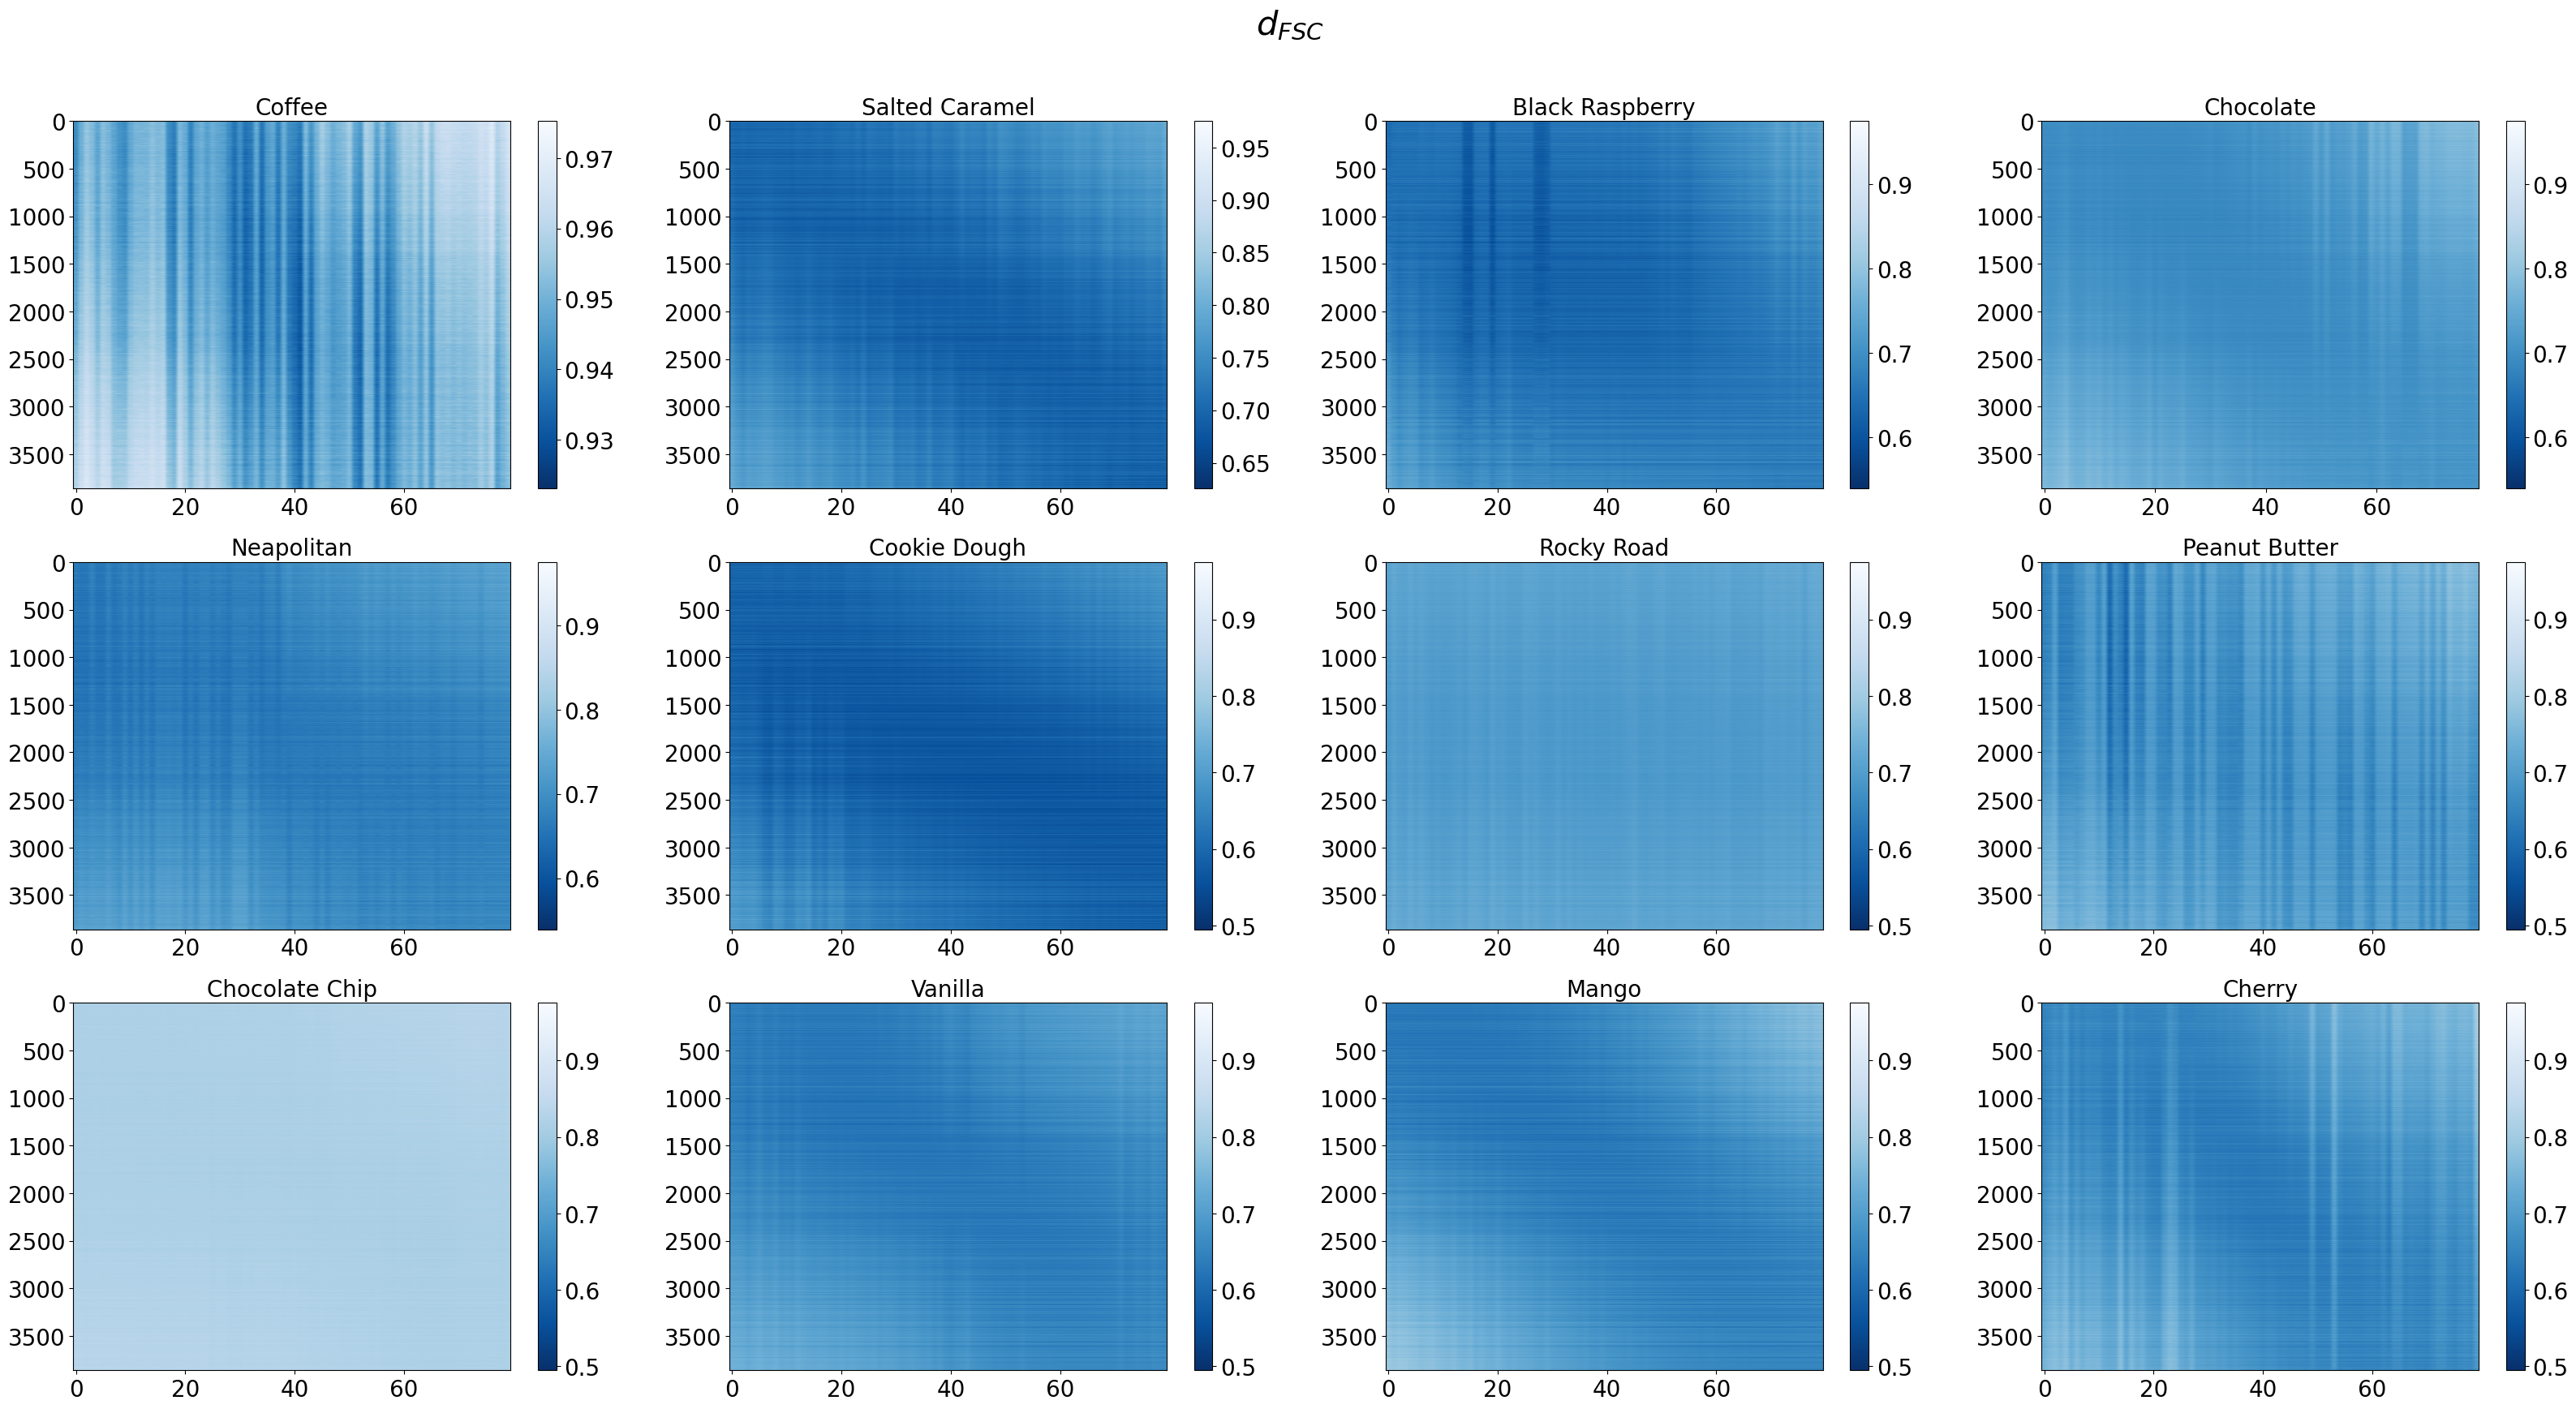

In [23]:
def plot_fsc_distances(data_d, gt_ordering):

    smaller_fontsize = 20
    larger_fontsize = 30
    n_plts = 12
    vmin, vmax = np.inf, -np.inf

    fig, axis = plt.subplots(3,n_plts//3,
                            figsize=(40,20),
                            # dpi=100,
                            )
    fig.suptitle(r'$d_{FSC}$', y=0.95, fontsize=larger_fontsize)

    for idx, (anonymous_label, data) in enumerate(data_d.items()):
        map2map_dist_matrix = data['fsc']['cost_matrix'].iloc[gt_ordering].values
        sorted_map2map_dist_matrix, indices, transport = sort_by_transport(map2map_dist_matrix)


        ncols = 4
        if map2map_dist_matrix.min() < vmin:
            vmin = map2map_dist_matrix.min()
        if map2map_dist_matrix.max() > vmax:
            vmax = map2map_dist_matrix.max()

        ax = axis[idx//ncols,idx%ncols].imshow(sorted_map2map_dist_matrix, aspect='auto', cmap='Blues_r', vmin=vmin, vmax=vmax)


        axis[idx//ncols,idx%ncols].tick_params(axis='both', labelsize=smaller_fontsize)
        cbar = fig.colorbar(ax)
        cbar.ax.tick_params(labelsize=smaller_fontsize)
        plot_panel_label = anonymous_label
        axis[idx//ncols,idx%ncols].set_title(plot_panel_label, fontsize=smaller_fontsize)

plot_fsc_distances(data_d, gt_ordering)

# Resolution at 0.5 FSC

In [24]:
def get_full_fsc_curve(fnames):
    data_d = {}
    for fname in fnames:
        if fname not in data_d.keys():
            with open(fname, 'rb') as f:
                data = pickle.load(f)
                anonymous_label = data['fsc']['user_submission_label']
                data_d[anonymous_label] = data['fsc']['computed_assets']['fsc_matrix']
    return data_d

fscs_sorted_d = get_full_fsc_curve(config.map2map_results)

In [28]:
res_fsc_half, fraction_nyquist = res_at_fsc_threshold(fscs_sorted_d['Cookie Dough'], threshold=0.5)
n_fourier_bins = fscs_sorted_d['Cookie Dough'].shape[-1]
units_Angstroms = 2 * 2.146 / (np.arange(1,n_fourier_bins+1) / n_fourier_bins)

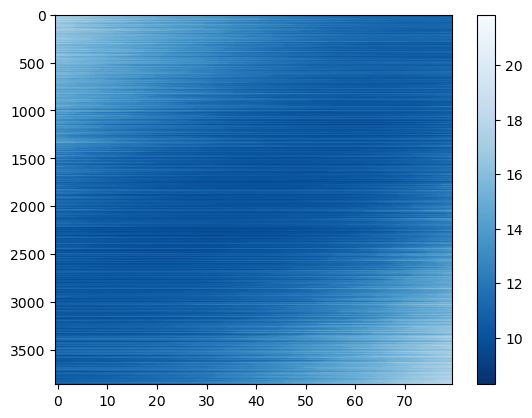

In [29]:
plt.imshow(units_Angstroms[res_fsc_half][gt_ordering], aspect='auto', cmap='Blues_r')
plt.colorbar()

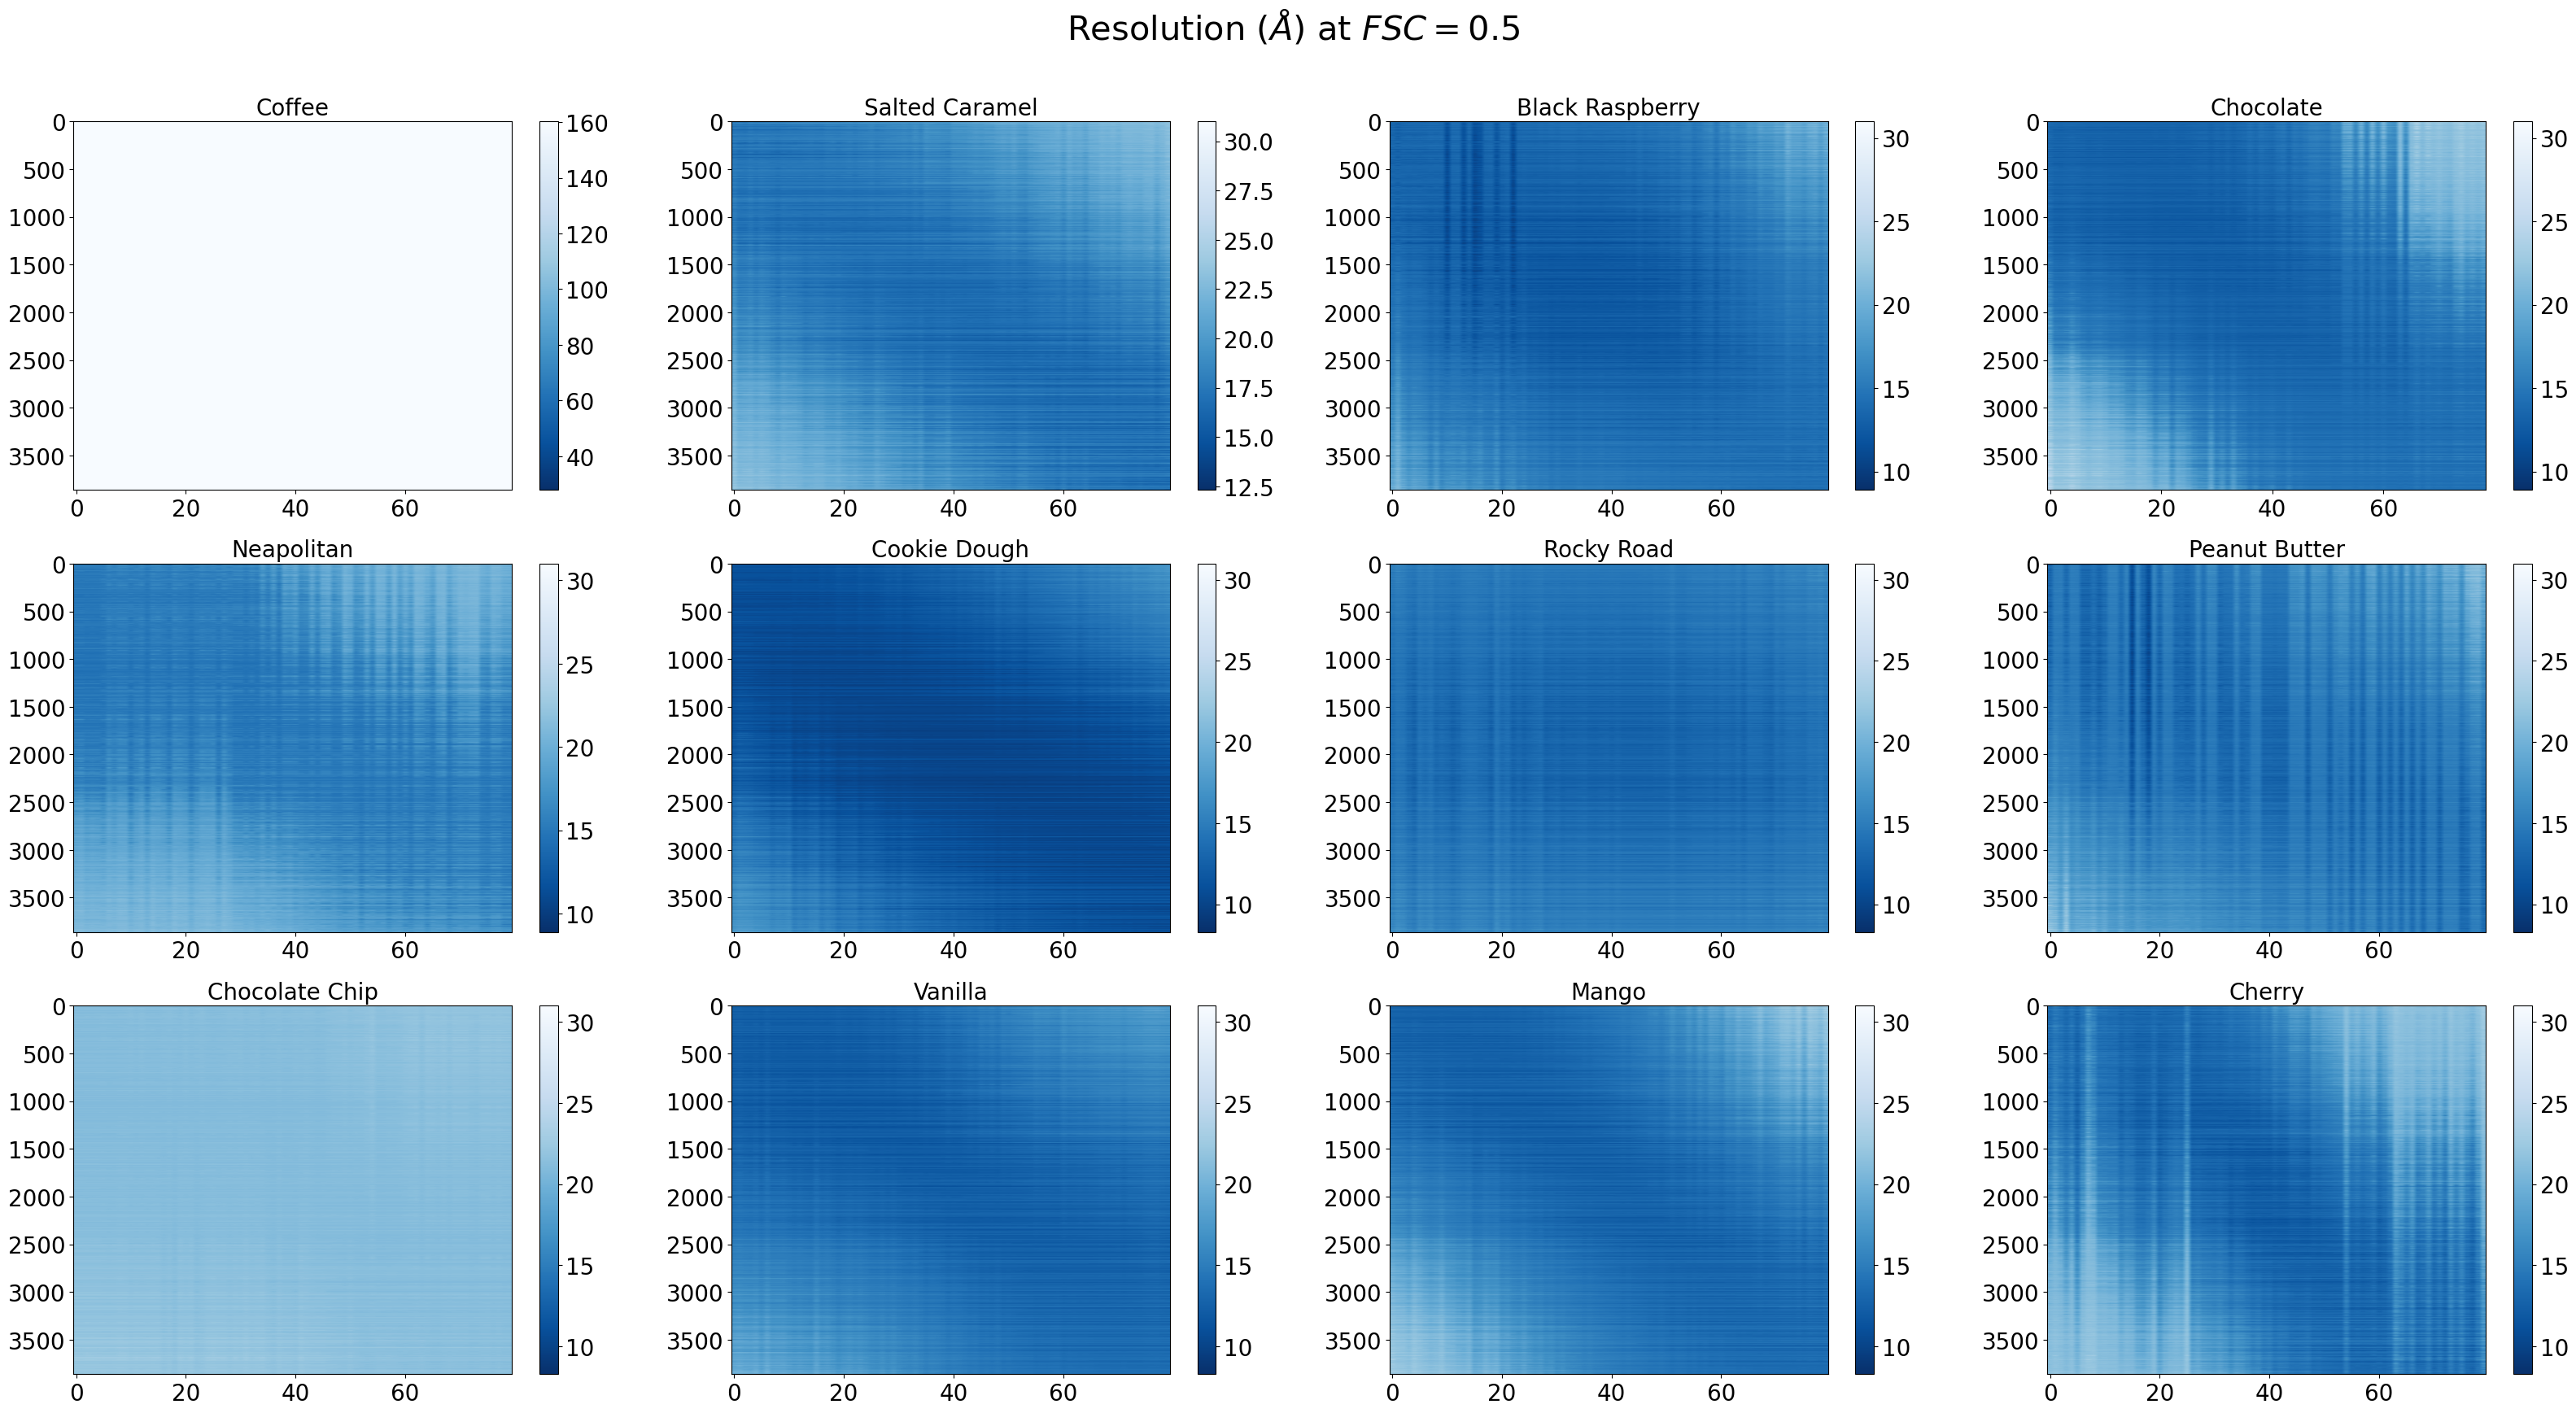

In [30]:
def plot_res_at_fsc_threshold_distances(fscs_sorted_d, gt_ordering, overwrite_dict={}):

    smaller_fontsize = 20
    larger_fontsize = 30
    n_plts = 12
    vmin, vmax = np.inf, -np.inf

    fig, axis = plt.subplots(3,n_plts//3,
                            figsize=(40,20),
                            # dpi=100,
                            )
    fig.suptitle(r'Resolution $(\AA)$ at $FSC=0.5$', y=0.95, fontsize=larger_fontsize)

    for idx, (anonymous_label, fscs) in enumerate(fscs_sorted_d.items()):
        # map2map_dist_matrix = data.iloc[gt_ordering].values
        res_fsc_half, _ = res_at_fsc_threshold(fscs, threshold=0.5)
        map2map_dist_matrix = units_Angstroms[res_fsc_half][gt_ordering]

        sorted_map2map_dist_matrix, _, _ = sort_by_transport(map2map_dist_matrix)


        ncols = 4
        if map2map_dist_matrix.min() < vmin:
            vmin = map2map_dist_matrix.min()
        if map2map_dist_matrix.max() > vmax:
            vmax = map2map_dist_matrix.max()
        if 'vmax' in overwrite_dict.keys():
            vmax = overwrite_dict['vmax']
        if 'vmin' in overwrite_dict.keys():
            vmin = overwrite_dict['vmin']

        ax = axis[idx//ncols,idx%ncols].imshow(sorted_map2map_dist_matrix, aspect='auto', cmap='Blues_r', vmin=vmin, vmax=vmax)


        axis[idx//ncols,idx%ncols].tick_params(axis='both', labelsize=smaller_fontsize)
        cbar = fig.colorbar(ax)
        cbar.ax.tick_params(labelsize=smaller_fontsize)
        plot_panel_label = anonymous_label
        axis[idx//ncols,idx%ncols].set_title(plot_panel_label, fontsize=smaller_fontsize)

plot_res_at_fsc_threshold_distances(fscs_sorted_d, gt_ordering, overwrite_dict={'vmax': 31})

# Optimal Probability Distribution (q_opt)

In [32]:
fname = config.dist2dist_results['prob_submitted_plot']['pkl_fnames'][0]

with open(fname, 'rb') as f:
    data = pickle.load(f)

In [33]:
def get_dist2dist_results(fnames):
    data_d = {}
    for fname in fnames:
        if fname not in data_d.keys():
            with open(fname, 'rb') as f:
                data = pickle.load(f)
                anonymous_label = data['id']
                data_d[anonymous_label] = data
    return data_d

dist2dist_results_d = get_dist2dist_results(config.dist2dist_results['prob_submitted_plot']['pkl_fnames'])

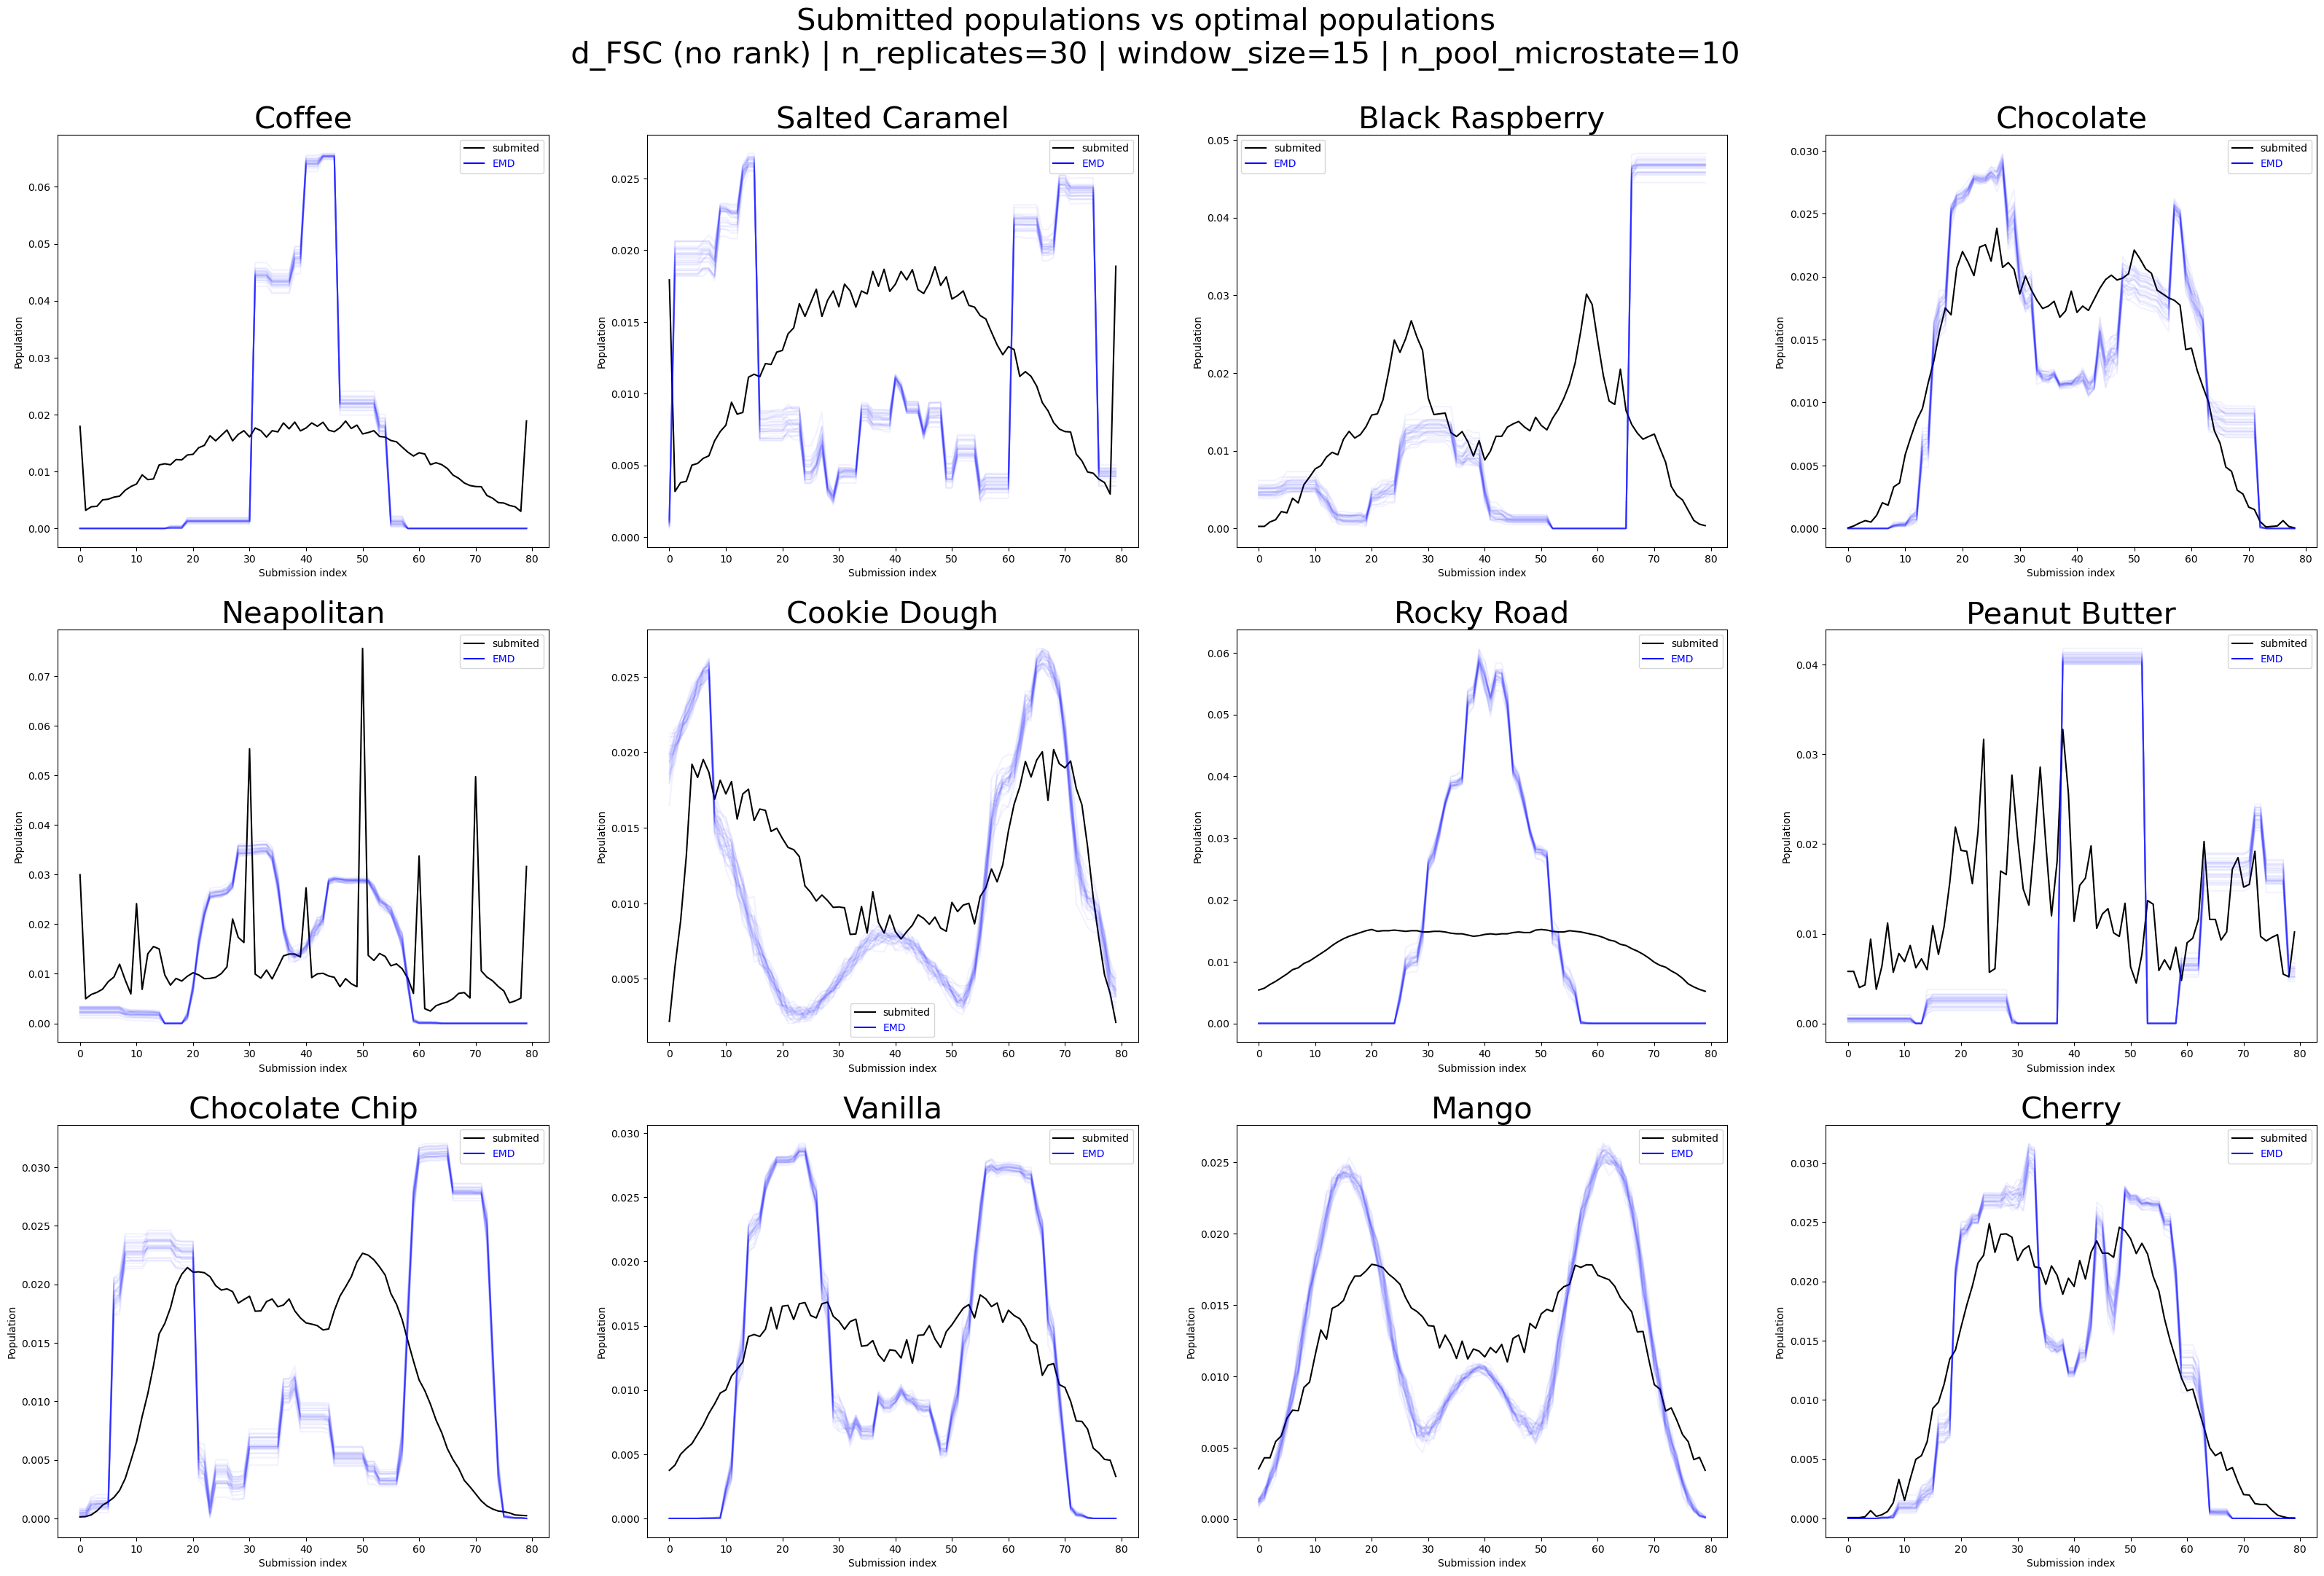

In [34]:
window_size = 15
nrows, ncols = 3,4
suptitle = f"Submitted populations vs optimal populations \n d_FSC (no rank) | n_replicates={data['config']['n_replicates']} | window_size={window_size} | n_pool_microstate={data['config']['n_pool_microstate']}"

def plot_q_opt_distances(dist2dist_results_d, suptitle, nrows, ncols):

    fig, axes = plt.subplots(nrows, ncols, figsize=(40,25))
    
    fig.suptitle(
        suptitle,
        fontsize=30,
    y=0.95)
    alpha = 0.05

    for idx_fname, (_,data) in enumerate(dist2dist_results_d.items()):
            

        axes[idx_fname//ncols, idx_fname%ncols].plot(data['user_submitted_populations'], color='black', label='submited')
        axes[idx_fname//ncols, idx_fname%ncols].set_title(data['id'], fontsize=30)

        def window_q(q_opt,window_size):
            running_avg = np.convolve(q_opt, np.ones(window_size)/window_size, mode='same')
            return running_avg
        
        for replicate_idx in range(data['config']['n_replicates']):
            
            if replicate_idx == 0: 
                label_d = {'EMD': 'EMD', 'KL': 'KL', 'KL_raw': 'Unwindowed', 'EMD_raw': 'Unwindowed'}
            else:
                label_d = {'EMD': None, 'KL': None, 'KL_raw': None, 'EMD_raw': None}
            axes[idx_fname//ncols, idx_fname%ncols].plot(window_q(data['fsc']['replicates'][replicate_idx]['EMD']['q_opt'],window_size), color='blue', alpha=alpha, label=label_d['EMD'])

            axes[idx_fname//ncols, idx_fname%ncols].set_xlabel('Submission index')
            axes[idx_fname//ncols, idx_fname%ncols].set_ylabel('Population')

            legend = axes[idx_fname//ncols, idx_fname%ncols].legend()
            for line, text in zip(legend.get_lines(), legend.get_texts()):
                text.set_color(line.get_color())
                line.set_alpha(1)

plot_q_opt_distances(dist2dist_results_d, suptitle,nrows, ncols)

# EMD vs EMD opt

In [35]:
def wragle_pkl_to_dataframe(pkl_globs):

    fnames = []
    for fname_glob in pkl_globs:
        fnames.extend(glob.glob(fname_glob))

    fnames = natsorted(fnames)

    df_list = []
    n_replicates = 30
    metric = 'fsc'

    for fname in fnames:
        with open(fname, 'rb') as f:
            data = pickle.load(f)

        df_list.append(pd.DataFrame({
        'EMD_opt': [data[metric]['replicates'][i]['EMD']['EMD_opt'] for i in range(n_replicates)],
        'EMD_submitted': [data[metric]['replicates'][i]['EMD']['EMD_submitted'] for i in range(n_replicates)],
        'klpq_opt': [data[metric]['replicates'][i]['KL']['klpq_opt'] for i in range(n_replicates)],
        'klqp_opt': [data[metric]['replicates'][i]['KL']['klqp_opt'] for i in range(n_replicates)],
        'klpq_submitted': [data[metric]['replicates'][i]['KL']['klpq_submitted'] for i in range(n_replicates)], 
        'klqp_submitted': [data[metric]['replicates'][i]['KL']['klqp_submitted'] for i in range(n_replicates)], 
        'id': data['id'],
        'n_pool_microstate': data['config']['n_pool_microstate'],
        }))

    df = pd.concat(df_list)
    df['EMD_opt_norm'] = df['EMD_opt'] / df['n_pool_microstate']
    df['EMD_submitted_norm'] = df['EMD_submitted'] / df['n_pool_microstate']

    return df


In [36]:
df = wragle_pkl_to_dataframe(config.dist2dist_results['emd_plot']['pkl_globs'])

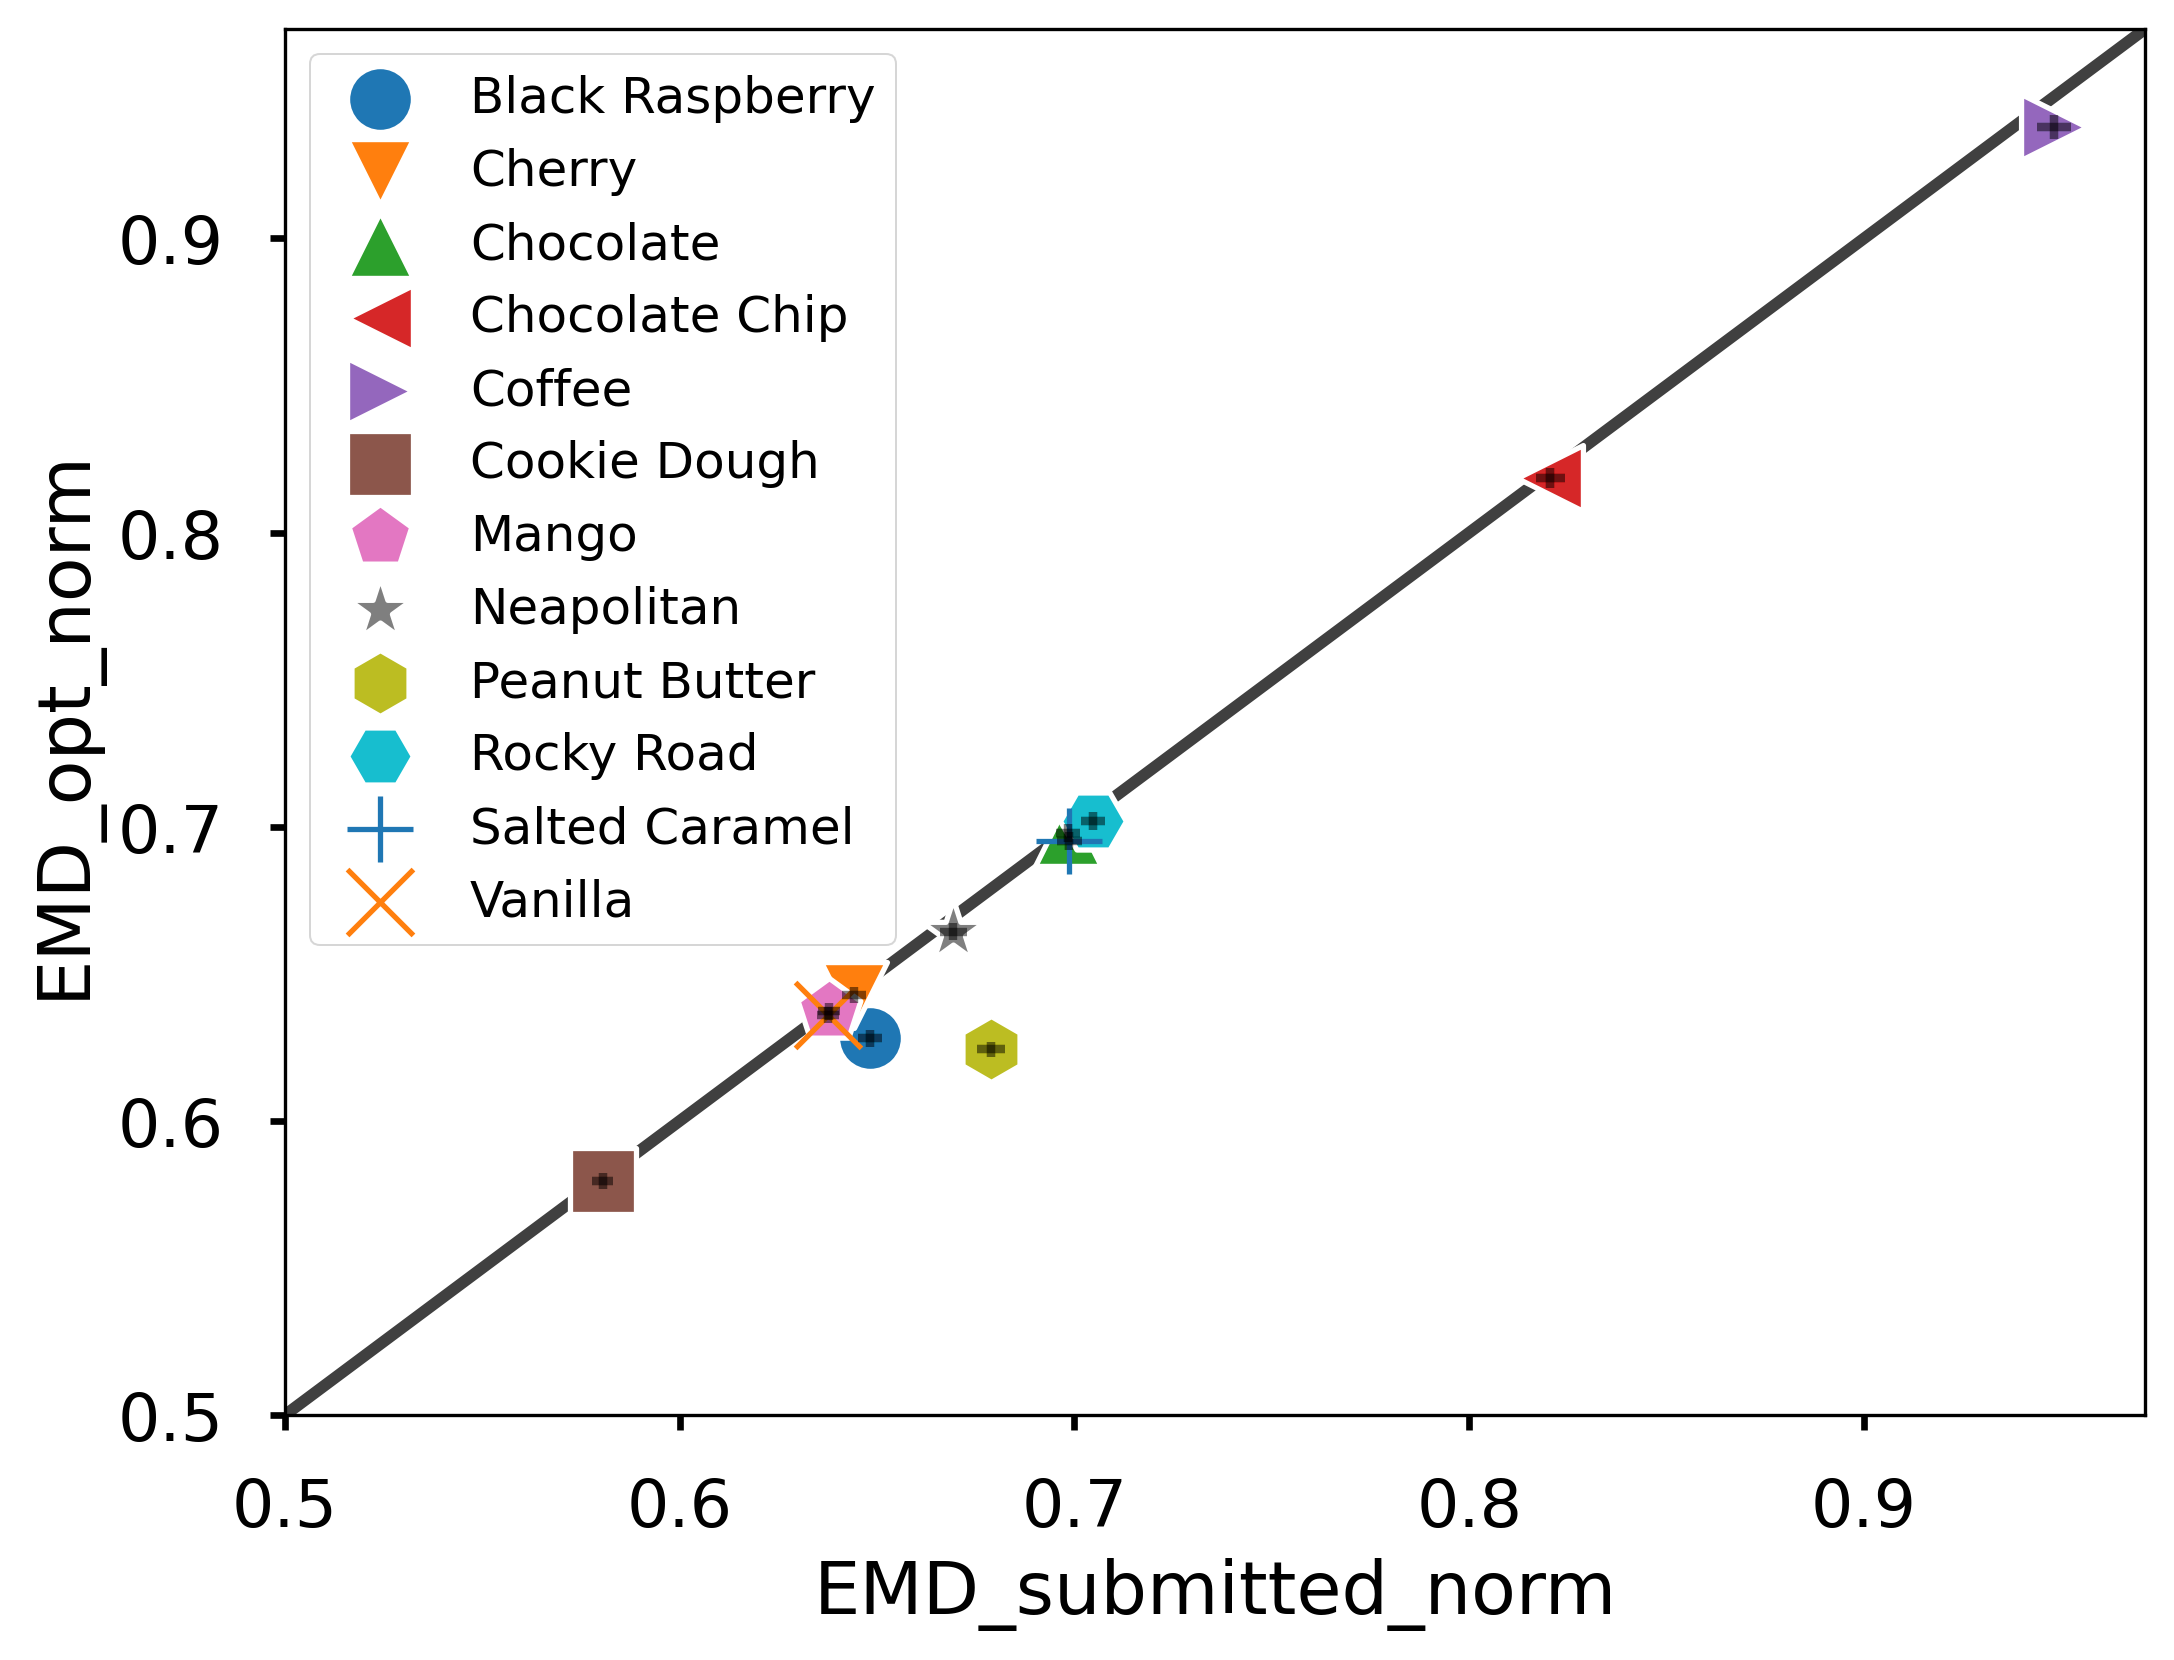

In [37]:
def plot_EMD_vs_EMDopt(df, suptitle=None):
    alpha = 1
    df_average = df.groupby(['n_pool_microstate','id']).mean().reset_index()
    df_std = df_average.groupby(['id']).std().reset_index().filter(['EMD_opt_norm','EMD_submitted_norm', 'id']).rename(columns={'EMD_opt_norm':'EMD_opt_norm_std', 'EMD_submitted_norm':'EMD_submitted_norm_std'})
    df_average = df.groupby(['id']).mean().reset_index()

    df_average_and_error = pd.merge(df_average, df_std, on='id')

    # Get unique ids
    ids = df_average_and_error['id'].unique()

    # Define marker styles
    markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
    marker_size = 250

    plt.style.use('seaborn-v0_8-poster')
    plot_width, plot_height = 8,6
    plt.figure(figsize=(plot_width, plot_height), dpi=300)

    # Create a scatter plot for each id
    for idx, id_label in enumerate(ids):
        df_average_id = df_average[df_average['id'] == id_label]
        sns.scatterplot(x='EMD_submitted_norm', y='EMD_opt_norm', data=df_average_id, alpha=alpha, marker=markers[idx % len(markers)], label=id_label, s=marker_size)

        plt.errorbar(x=df_average_and_error['EMD_submitted_norm'], 
                y=df_average_and_error['EMD_opt_norm'], 
                xerr=df_average_and_error['EMD_submitted_norm_std'], 
                yerr=df_average_and_error['EMD_opt_norm_std'], 
                fmt='', alpha=0.05, linestyle='None', ecolor='k', elinewidth=2, capsize=5)

    plt.xlim(left=0.5)
    plt.ylim(bottom=0.5)

    limits = [np.min([plt.xlim(), plt.ylim()]),  # min of both axes
            np.max([plt.xlim(), plt.ylim()])]  # max of both axes

    plt.plot(limits, limits, 'k-', alpha=0.75, zorder=0)
    plt.xlim(limits)
    plt.ylim(limits)
    legend = plt.legend(loc='upper left', fontsize=12)
    for handle in legend.legend_handles:
        handle.set_alpha(1)

    plt.suptitle(suptitle)

suptitle = r'$d_{FSC}$ (no rank)'
plot_EMD_vs_EMDopt(df, suptitle=None)